<a href="https://colab.research.google.com/github/sskunkworks/ai-notebook/blob/main/test_road_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-xk9e328l
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-xk9e328l
  Created wheel for tensorflow-examples: filename=tensorflow_examples-fa33ab053877a0acbee1b78c5e3120554b94e5a5_-cp37-none-any.whl size=265841 sha256=3f51f2b302a3b958618aa71c06addfae4afb99d37f1092eed482a92323e49bb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-i8x14k6m/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 4.0MB 8.4MB/s 


In [3]:
import tensorflow as tf

In [31]:
#from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import PIL
import sys
import os
from copy import deepcopy
from glob import glob
from unittest import mock
import re
import numpy as np
import random
import os.path
import scipy.misc
import shutil
import zipfile
import time
from glob import glob
from glob import glob1
from urllib.request import urlretrieve
from tqdm import tqdm
from PIL import Image

In [4]:
def test_for_kitti_dataset(data_dir):
    kitti_dataset_path    = os.path.join(data_dir, 'data_road')
    training_labels_count = len(glob(os.path.join(kitti_dataset_path, 'training/gt_image_2/*_road_*.png')))
    training_images_count = len(glob(os.path.join(kitti_dataset_path, 'training/image_2/*.png')))
    testing_images_count  = len(glob(os.path.join(kitti_dataset_path, 'testing/image_2/*.png')))

    assert not (training_images_count == training_labels_count == testing_images_count == 0),\
        'Kitti dataset not found. Extract Kitti dataset in {}'.format(kitti_dataset_path)
    assert training_images_count == 289, 'Expected 289 training images, found {} images.'.format(training_images_count)
    assert training_labels_count == 289, 'Expected 289 training labels, found {} labels.'.format(training_labels_count)
    assert testing_images_count == 290, 'Expected 290 testing images, found {} images.'.format(testing_images_count)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0 255 255 ...   0   0   0]
 [  0 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


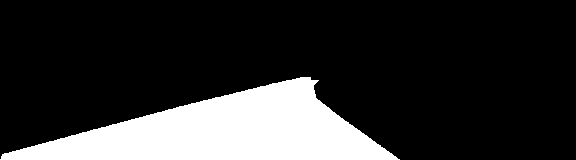

In [84]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

# def gen_batch_function(data_folder, image_shape):
#     """
#     Generate function to create batches of training data
#     :param data_folder: Path to folder that contains all the datasets
#     :param image_shape: Tuple - Shape of image
#     :return:
#     """
def get_batches_fn(data_folder, image_shape, batch_size):
  """
  Create batches of training data
  :param batch_size: Batch Size
  :return: Batches of training data
  """
  image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
  label_paths = {
      re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
      for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
  
  background_color = np.array([255, 0, 255]) # Red color

  # image를 셔플링한다.
  random.shuffle(image_paths)
  # 셔플된 이미지에서 batch 크기만큼씩 index를 증가시킨다.
  for batch_i in range(0, len(image_paths), batch_size):
      images = []
      gt_images = []
      # 셔플된 이미지들에서 파일을 읽어오면서 처리한다.
      for image_file in image_paths[batch_i:batch_i+batch_size]:
          # 라벨 이름을 가져온다.
          gt_image_file = label_paths[os.path.basename(image_file)]

          # image, gt image를 가져와서 리사이징한다.
          image = cv2.resize(np.array(cv2.imread(image_file)),image_shape)
          gt_image = cv2.resize(np.array(cv2.imread(gt_image_file)), image_shape)
          
          # 설정 컬러와 동일한 데이터만 라벨링하고 그 외에는 백그라운드로 처리한다.
          # Red channel 사용하여 비교한다.
          gt_bg = np.all(gt_image == background_color, axis=2)
          return gt_bg
          break
          gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
          print('hi6')
          print(gt_bg.shape, np.invert(gt_bg).shape)
          gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
          print('hi7')
          images.append(image)
          gt_images.append(gt_image)
      break
      #yield np.array(images), np.array(gt_images)
#return get_batches_fn

gt_image = get_batches_fn(os.path.join(data_dir, 'data_road/training'), image_shape, batch_size)
img = gt_image.astype(np.uint8)
img *= 255
print(img)
cv2_imshow(img)



In [63]:
num_classes = 2
image_shape = (576, 160)
data_dir = 'drive/MyDrive/datasets/'
#runs_dir = './runs'
test_for_kitti_dataset(data_dir)
#get_batches_fn = gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

#test_for_kitti_dataset('drive/MyDrive/datasets/')

In [8]:
data_folder = os.path.join(data_dir, 'data_road/training')
batch_size = 30
for i in get_batches_fn(os.path.join(data_dir, 'data_road/training'), image_shape, batch_size):
  print(i)
# for image, label in get_batches_fn(data_folder, batch_size, image_shape):
#   print(image, label)  
# image_file = 'drive/MyDrive/datasets/data_road/training/image_2/umm_000048.png'
# img = Image.open(image_file)
# print(img.getdata())
# img_arr = np.array(img.getdata())
# print(np.resize(img_arr,image_shape).shape)

[[255   0   0 ... 255   0   0]
 [255   0   0 ... 255   0   0]
 [255   0   0 ... 255   0   0]
 ...
 [255   0   0 ... 255   0   0]
 [255   0   0 ... 255   0   0]
 [255   0   0 ... 255   0   0]]


TypeError: ignored

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 건너뛰기 연결을 업샘플링하고 설정하세요
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])